In [29]:
# libraries
import mne
import glob
import numpy as np
%matplotlib widget
from os import chdir, makedirs
from os.path import join
import matplotlib.pyplot as plt ## for basic plotting
import matplotlib as mpl ## for setting default parameters
import pandas as pd

# decoding libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from joblib import Parallel, delayed


In [3]:
# paths
subject = '0169'
workshop_date = '20250923'
MEG_path = f"/work/MEG_data/workshop_data/{subject}/{workshop_date}_000000" ## you can pick your study group member
subjects_dir = '/work/freesurfer'
behaviour_path = '/work/MEG_data/workshop_data/behavioural_logs'

In [4]:
# load MEG data
raw = mne.io.read_raw_fif(join(MEG_path, 'workshop_2025_raw.fif'), preload=True) 
#fig = raw.plot()

# load behavioral data
files = glob.glob(f"{behaviour_path}/{subject}*_experiment_data.csv") # match any file that starts with subject number
if files:
    behaviour = pd.read_csv(files[0], index_col=False)
else:
    print("No matching files found")

Opening raw data file /work/MEG_data/workshop_data/0169/20250923_000000/workshop_2025_raw.fif...
    Read a total of 9 projection items:
        planar-Raw-0.000-120.000-PCA-01 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-02 (1 x 203)  idle
        planar-Raw-0.000-120.000-PCA-03 (1 x 203)  idle
        axial-Raw-0.000-120.000-PCA-01 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-02 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-03 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-04 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-05 (1 x 102)  idle
        axial-Raw-0.000-120.000-PCA-06 (1 x 102)  idle
    Range : 2024000 ... 3601999 =   2024.000 ...  3601.999 secs
Ready.
Reading 0 ... 1577999  =      0.000 ...  1577.999 secs...


In [5]:
# reject bad channels
raw.info['bads'] = ['EOG002']  # mark channels as bad

In [6]:
# filter by frequency
raw.filter(h_freq=40, l_freq=1) # band pass

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



<Raw | workshop_2025_raw.fif, 313 x 1578000 (1578.0 s), ~3.69 GiB, data loaded>

In [7]:
# find events
events = mne.find_events(raw)

# identify event indices where stimulus is shown (event code 1 and 3)
target_indices = events[ : , 2] < 4

# rename those events by a code indicating their following PAS score
events[target_indices, 2] = behaviour['subjective_response'] + 20

#behaviour['subjective_response'].value_counts()

Finding events on: STI101
1600 events found on stim channel STI101
Event IDs: [ 1  3  4  6  8 10 12 14 16]


In [8]:
# prepare dict with event names
event_id = dict(NE=21, WG=22, ACE=23, CE=24)

# creating epochs
epochs = mne.Epochs(raw,
                    events,
                    event_id = event_id,
                    tmin = -0.200,
                    tmax = 0.550,
                    baseline = (-0.200, 0),
                    preload = True)

epochs_eog_cleaned = mne.Epochs(raw,
                    events,
                    event_id = event_id,
                    tmin = -0.200,
                    tmax = 0.550,
                    baseline = (-0.200, 0),
                    reject = dict(eog=250e-6), # rejecting epochs with eog signal above 250 microvolt
                    preload = True) # telling it to apply the rejection

Not setting metadata


400 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 400 events and 751 original time points ...
0 bad epochs dropped
Not setting metadata
400 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 9)
9 projection items activated
Using data from preloaded Raw for 400 events and 751 original time points ...
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EOG001']
    Rejecting  epoch based on EOG : ['EO

In [9]:
epochs_eog_cleaned

<Epochs | 336 events (all good), -0.2 – 0.55 s (baseline -0.2 – 0 s), ~607.8 MiB, data loaded,
 'NE': 58
 'WG': 127
 'ACE': 94
 'CE': 57>

In [10]:
# creating averages (evoked responses) and difference waves
evokeds = list()
for event in epochs.event_id:
    evokeds.append(epochs[event].average())

evoked_diffs = list()
diffs_comment = ['CE - NE']
diffs = [(3,0)]
for diff in diffs:
    evoked_diff = evokeds[diff[0]].copy() # create a copy
    evoked_diff.data -= evokeds[diff[1]].data # modify the data in place
    evoked_diff.comment = diffs_comment
    evoked_diffs.append(evoked_diff)

# making another one without eog-rejected epochs
evokeds_filtered = list()
for event in epochs_eog_cleaned.event_id:
    evokeds_filtered.append(epochs_eog_cleaned[event].average())

evoked_filtered_diffs = list()
diffs_comment = ['CE - NE']
diffs = [(3,0)]
for diff in diffs:
    evoked_filtered_diff = evokeds_filtered[diff[0]].copy() # create a copy
    evoked_filtered_diff.data -= evokeds_filtered[diff[1]].data # modify the data in place
    evoked_filtered_diff.comment = diffs_comment
    evoked_filtered_diffs.append(evoked_filtered_diff)

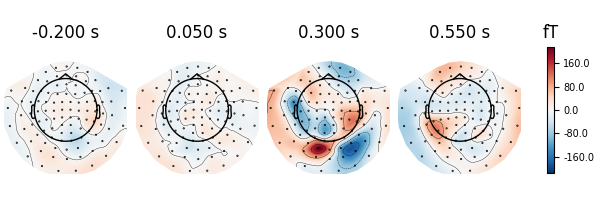

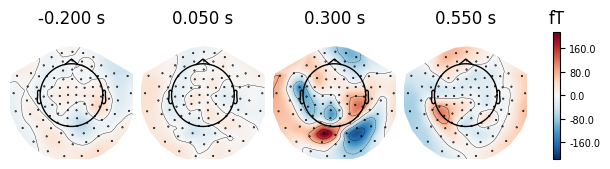

In [11]:
mne.viz.plot_evoked_topomap(evokeds[0])

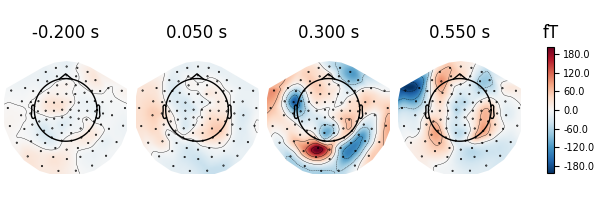

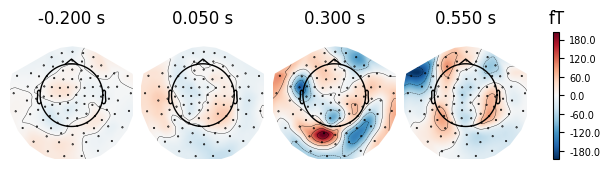

In [12]:
mne.viz.plot_evoked_topomap(evokeds[3])

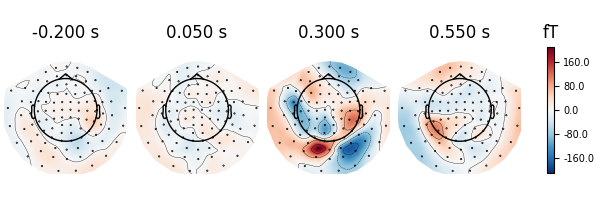

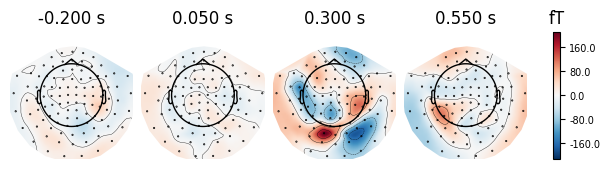

In [14]:
mne.viz.plot_evoked_topomap(evokeds_filtered[0])

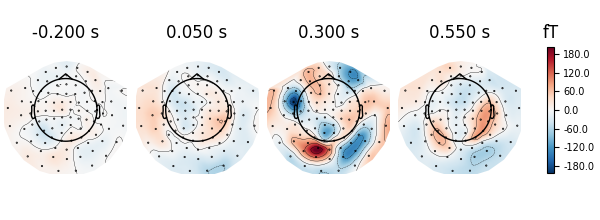

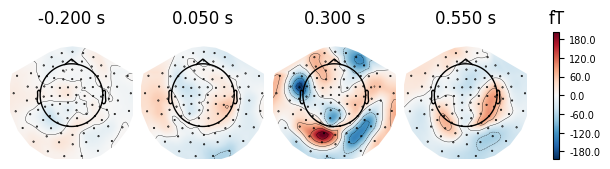

In [15]:
mne.viz.plot_evoked_topomap(evokeds_filtered[3])

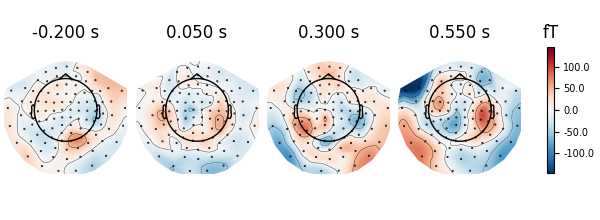

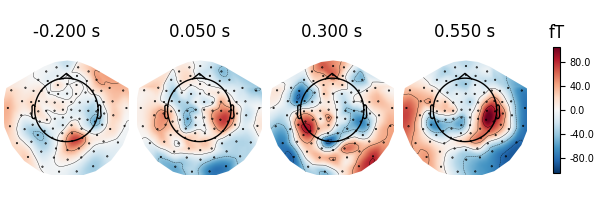

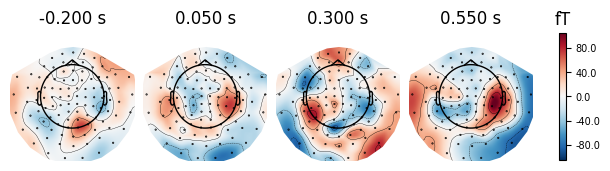

In [24]:
mne.viz.plot_evoked_topomap(evoked_diffs[0])
mne.viz.plot_evoked_topomap(evoked_filtered_diffs[0])

In [25]:
# get forward model
info = evoked_filtered_diff.info
trans = join(MEG_path, 'workshop_2025-trans.fif')
src = join(subjects_dir, subject, 'bem', subject + '-oct-6-src.fif')
bem = join(subjects_dir, subject, 'bem', subject + '-5120-bem-sol.fif')

fwd = mne.make_forward_solution(
                            info, trans,
                            src, bem)

# save model
makedirs('models', exist_ok=True) # making sure folder exists
mne.write_forward_solution(f'models/{subject}-fwd.fif', fwd, overwrite=True)

Source space          : /work/freesurfer/0169/bem/0169-oct-6-src.fif
MRI -> head transform : /work/MEG_data/workshop_data/0169/20250923_000000/workshop_2025-trans.fif
Measurement data      : instance of Info
Conductor model   : /work/freesurfer/0169/bem/0169-5120-bem-sol.fif
Accurate field computations
Do computations in head coordinates
Free source orientations

Reading /work/freesurfer/0169/bem/0169-oct-6-src.fif...
Read 2 source spaces a total of 8196 active source locations

Coordinate transformation: MRI (surface RAS) -> head
    0.999953 -0.002030 -0.009481      -0.95 mm
    0.005052 0.943696 0.330775      13.10 mm
    0.008275 -0.330807 0.943662      27.80 mm
    0.000000 0.000000 0.000000       1.00

Read 306 MEG channels from info
105 coil definitions read
Coordinate transformation: MEG device -> head
    0.994255 0.105501 0.018056       4.03 mm
    -0.105149 0.994267 -0.019438       1.63 mm
    -0.020003 0.017428 0.999648      62.97 mm
    0.000000 0.000000 0.000000       1.0

In [26]:
# load saved model
#fwd = mne.read_forward_solution(f'models/{subject}-fwd.fif')

    Created an SSP operator (subspace dimension = 9)
    Setting small MEG eigenvalues to zero (without PCA)
Reducing data rank from 306 -> 297
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 80400
[done]
Computing rank from covariance with rank=None
    Using tolerance 5.2e-15 (2.2e-16 eps * 102 dim * 0.23  max singular value)
    Estimated rank (mag): 96
    MAG: rank 96 computed from 102 data channels with 0 projectors
Computing rank from covariance with rank=None
    Using tolerance 1.1e-13 (2.2e-16 eps * 204 dim * 2.5  max singular value)
    Estimated rank (grad): 201
    GRAD: rank 201 computed from 204 data channels with 0 projectors


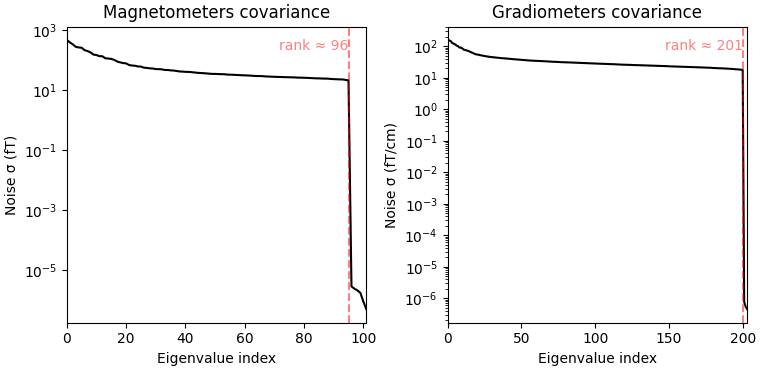

(<Figure size 760x370 with 4 Axes>, <Figure size 760x370 with 2 Axes>)

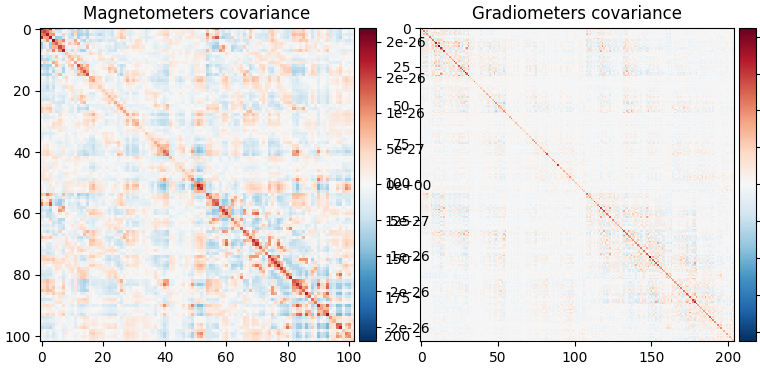

In [27]:
noise_cov = mne.compute_covariance(epochs, tmin=None, tmax=0)
noise_cov.plot(raw.info)

In [28]:
inverse_operator = mne.minimum_norm.make_inverse_operator(epochs.info, fwd,
                                                          noise_cov)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
info["bads"] and noise_cov["bads"] do not match, excluding bad channels from both
Computing inverse operator with 306 channels.
    306 out of 306 channels remain after picking
Selected 306 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 7618/8196 = 10.000578
    scale = 4.63926e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 9)
Computing rank from covariance with rank=None
    Using tolerance 1.8e-13 (2.2e-16 eps * 306 dim * 2.6  max singular value)
    Estimated rank (mag + grad): 297
    MEG: rank 297 computed from 306 data channels with 9 projectors


    Setting small MEG eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weighted lead field matrix.
    largest singular value = 5.17182
    scaling factor to adjust the trace = 1.18851e+19 (nchan = 306 nzero = 9)


In [21]:
epochs_decoding = epochs_eog_cleaned

In [22]:
##FILTERING as to only use events NE and CE

# And the event codes you want to keep are 21 and 24

filter_events = [21, 24]

# Create a boolean mask for the epochs you want

mask = np.isin(epochs_decoding.events[:, 2], filter_events)

  

# Apply the mask to get filtered epochs

epochs_filtered = epochs_decoding[mask]

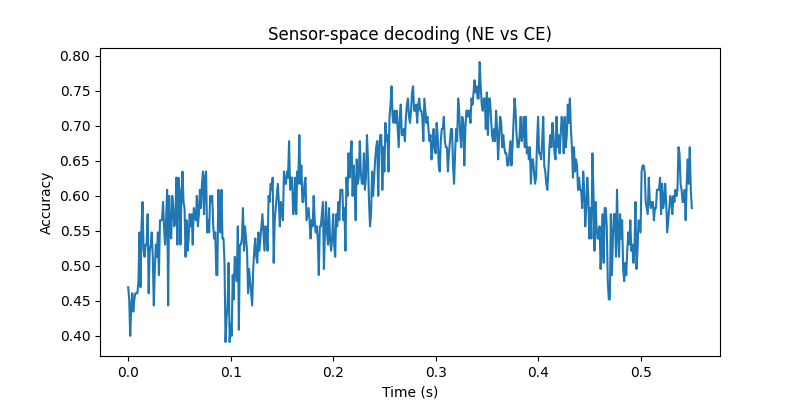

In [30]:
## deocoding in sensor space

# -------------------------------
# PARAMETERS
# -------------------------------
n_jobs_outer = 64
decimation = 1
cv_folds = 5
C_reg = 1e-3
n_skip = 200  # discard first 200 samples

# -------------------------------
# USE SENSOR-LEVEL EPOCHS DIRECTLY
# -------------------------------
# (assume epochs_filtered contains only your relevant events)
X = epochs_filtered.get_data()  # shape = (n_events, n_channels, n_times)
y = epochs_filtered.events[:, 2]

# Optional: restrict to MEG or EEG channels only
# picks = mne.pick_types(epochs_filtered.info, meg=True, eeg=False)
# X = epochs_filtered.get_data(picks=picks)

# Drop pre-stim samples
X = X[:, :, n_skip:][:, :, ::decimation]
times = epochs_filtered.times[n_skip:][::decimation]
n_events, n_channels, n_samples = X.shape

# -------------------------------
# CLASSIFIER SETUP
# -------------------------------
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True)
logr = LogisticRegression(C=C_reg, solver='liblinear', max_iter=1000)
sc = StandardScaler()

# -------------------------------
# FUNCTION FOR SINGLE TIME SAMPLE
# -------------------------------
def decode_time_sample(sample_idx):
    this_X = X[:, :, sample_idx]
    this_X_std = sc.fit_transform(this_X)
    score = np.mean(cross_val_score(logr, this_X_std, y, cv=cv, n_jobs=1))
    return score

# -------------------------------
# PARALLEL DECODING
# -------------------------------
scores_list_samples = Parallel(n_jobs=n_jobs_outer)(
    delayed(decode_time_sample)(t) for t in range(n_samples)
)

# -------------------------------
# PLOT RESULTS
# -------------------------------
plt.figure(figsize=(8,4))
plt.plot(times, scores_list_samples)
plt.title('Sensor-space decoding (NE vs CE)')
plt.xlabel('Time (s)')
plt.ylabel('Accuracy')
plt.show()


Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 9)
    Created the whitener using a noise covariance matrix with rank 297 (9 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 306 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Processing epoch : 1 / 115
combining the current components...
Processing epoch : 2 / 115
combining the current components...
Processing epoch : 3 / 115
combining the current components...
Processing epoch : 4 / 115
combining the current components...
Processing epoch : 5 / 115
combining the current components...
Processing epoch : 6 / 115
combining the current components...
Processing epoch : 7 / 115
combining the current components...
Processing epoch : 8 / 115
combining the current components...
Processing epoch : 9 / 115
combining the curr

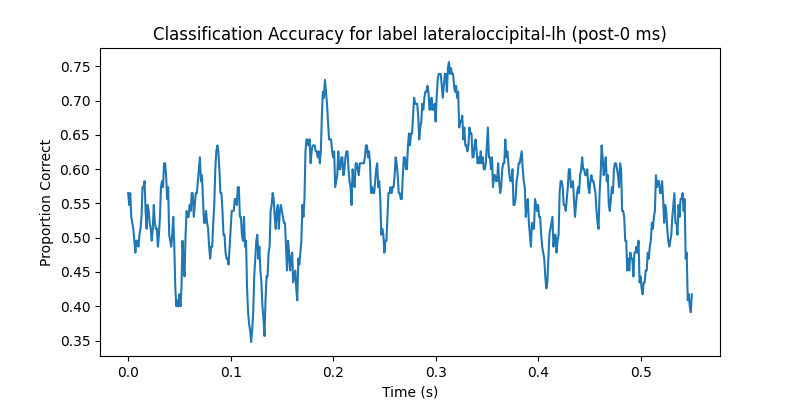

In [32]:
# DECODING IN SOURCE SPACE (works)

# -------------------------------

# PARAMETERS

# -------------------------------

n_jobs_outer = 64   # number of cores for time point parallelization

decimation = 1      # take every N-th sample (1 = no decimation)

cv_folds = 5

C_reg = 1e-3

label_index = 22    # label to decode  - this is lateral occipital

n_skip = 200        # number of initial samples to discard (pre-0 ms)

  

# -------------------------------

# APPLY INVERSE OPERATOR

# -------------------------------

stcs = mne.minimum_norm.apply_inverse_epochs(

    epochs_filtered, inverse_operator, lambda2=1, method='dSPM'

)

  

# -------------------------------

# READ LABELS

# -------------------------------

labels = mne.read_labels_from_annot('0169', subjects_dir=subjects_dir)

  

# -------------------------------

# EXTRACT LABELS

# -------------------------------

def extract_label(label, stcs):

    return [stc.in_label(label) for stc in stcs]

  

label_stcs = [extract_label(label, stcs) for label in labels]

  

# -------------------------------

# SELECT LABEL AND BUILD X

# -------------------------------

stcs_for_label = label_stcs[label_index]

label_name = labels[label_index].name

  

n_events = len(stcs_for_label)

n_label_vertices = stcs_for_label[0].data.shape[0]

n_samples = stcs_for_label[0].data.shape[1]

  

# Build X: shape = (n_events, n_vertices, n_samples)

X = np.zeros((n_events, n_label_vertices, n_samples))

for i in range(n_events):

    X[i, :, :] = stcs_for_label[i].data

  

# -------------------------------

# DISCARD FIRST 200 SAMPLES

# -------------------------------

X = X[:, :, n_skip:]

times = stcs_for_label[0].times[n_skip:]

n_samples = X.shape[2]

  

# -------------------------------

# LABELS

# -------------------------------

y = epochs_filtered.events[:, 2]

  

# -------------------------------

# CROSS-VALIDATION SETUP

# -------------------------------

cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

logr = LogisticRegression(C=C_reg, solver='liblinear', max_iter=1000)

sc = StandardScaler()

  

# -------------------------------

# FUNCTION TO DECODE ONE TIME SAMPLE

# -------------------------------

def decode_time_sample(sample_idx):

    this_X = X[:, :, sample_idx]

    this_X_std = sc.fit_transform(this_X)

    score = np.mean(cross_val_score(logr, this_X_std, y, cv=cv, n_jobs=1))
    return score

  

# -------------------------------

# PARALLEL DECODING ACROSS TIME POINTS

# -------------------------------

scores_list_samples = Parallel(n_jobs=n_jobs_outer)(
    delayed(decode_time_sample)(t) for t in range(n_samples)

)

  

# -------------------------------

# PLOT RESULTS

# -------------------------------

plt.figure(figsize=(8,4))

plt.plot(times, scores_list_samples)

plt.title(f'Classification Accuracy for label {label_name} (post-0 ms)')

plt.xlabel('Time (s)')

plt.ylabel('Proportion Correct')

plt.show()